# Cosmological Parameters

There are many constraints that can be placed on cosmological parameters using various observations. Type Ia supernova and the power spectrum of the cosmological microwave background are two examples. In this exercise we will use a different example: galaxy cluster counts.

The idea hypothesis under which we operate is the following: 

Galaxy cluster counts as a function of halo mass = Halo mass function.

$$
\frac{dn(M_{\rm cluster})}{dM_{\rm cluster}} = \frac{dn(M_{\rm halo})}{dM_{\rm halo}}
$$


First, we will load a sample of galaxy cluster masses from Vikhlinin et al. (2009) which can be used to infer cosmological parameters. Cluster masses have been determined in the redshift range $0.025 < z \leq 0.25$.

The goal of this exercise is to model the priors for cosmological parameters $H_0, \, \sigma_8$ and $\Omega_{\rm M}$ and the likelihood that given a model for the mass function (Tinker et al. 2008), we will observe the cluster counts of Vikhlinin et al. (2009).

The likelihood and priors can be used to infer the posterior distribution of the cosmological parameters, given the observational data.

Let us start with the data...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.optimize import minimize
from scipy.interpolate import interp1d


%matplotlib inline

# Load the data
data_low_z = np.genfromtxt("data/redshift_data_updated.txt")

# Extract the useful values from the data
mass_low_z = data_low_z[0]
mass_low_z_err = data_low_z[1]
z_low = data_low_z[2]

The following cells implement the model of Tinker et al. (2008) for the halo mass function, which depends on multiple cosmological parameters:

$$
\frac{dn}{d\log M} = f(\sigma) \frac{\Omega_{\rm M}\rho_{\rm c}}{M}\frac{d\log\sigma^{-1}}{d\log M},
$$

where $\rho_{\rm c} = 3H_0^2/(8\pi G)$ is the critical density of the Universe, $\sigma=\sigma(M)$ is the RMS value of cosmological density fluctuations of mass $M$, and $f(\sigma)$ is a function defined below and provided by Tinker et al. (2008). The model is closed by the relation of Jenkins et al. (2001):

$$
\sigma(M)\approx\sigma_{8}\left(\frac{M}{M_8}\right)^{-\frac{n_{\rm eff}-3}{6}},
$$

where $M_8$ is the average mass enclosed within 8 Mpc, and $n_{\rm eff}\approx-1.0$ for the standard $\Lambda{\rm CDM}$ cosmological model.


### Let us start implementing the model with a few useful variables and constants.

In [2]:
Mpc_in_cm = 3.086e24
Mpc_in_km = 3.086e19
Msun_in_g = 1.989e33

# convert G from cgs (cm^3/g/s^2) to Mpc^3/Msun/s^2
G_grav = 6.674e-8 * Msun_in_g / Mpc_in_cm**3

# Speed of light in cgs
c_light = 3.0e10 


# Cosmological parameters
mass_function_amplitude = 0.26
Delta = 500.0
n_eff = -1.0
R_8 = 8.0


# Trial value for H_0
# # H_0 is in units of km/s/Mpc
H_0 = 67.74
h = H_0/100.0

# survey area is 400 degrees^2
survey_volume = 400.0
z_min_low_z, z_max_low_z = 0.025, 0.25

In [3]:
# We also need to load data accounting for the selection function of the observations
effective_volume = np.genfromtxt("data/effective_volume.csv", delimiter=',')

effective_volume = interp1d(effective_volume[:,0]/h, effective_volume[:,1]/h**3, 
                            bounds_error=False, fill_value=9.28562539e+08)

### Cosmological Functions

Let us now implement the rest of the model. These functions contain all the cosmological parameterizations to model the galaxy cluster count.

In [4]:
def calc_a(Delta):
    return 1.43 + (np.log10(Delta) - 2.3)**1.5
def calc_b(Delta):
    return 1.0 + (np.log10(Delta) - 1.6)**(-1.5)
def calc_c(Delta):
    return 1.2 + (np.log10(Delta) - 2.35)**1.6
    
def calc_M_8(H_0):
    return 3.0*(H_0/Mpc_in_km)**2 / (8.0 * np.pi * G_grav) * (4.0*np.pi/3.0) * R_8**3

def calc_sigma(mass, H_0, sigma_8):
    
    M_8 = calc_M_8(H_0)
    sigma = sigma_8 * (mass/M_8)**((-3.0-n_eff)/6.0)
    
    return sigma
    
    
def calc_f_sigma(sigma):
    
    a = calc_a(Delta)
    b = calc_b(Delta)
    c = calc_c(Delta)
        
    f_sigma = np.exp(-c / sigma**2)
    f_sigma *= (b/sigma)**a + 1.0
    f_sigma *= mass_function_amplitude

    return f_sigma


def calc_dn_dlnM(mass, H_0, sigma_8, Omega_M):
    
    sigma = calc_sigma(mass, H_0, sigma_8)
    f_sigma = calc_f_sigma(sigma)
    
    critical_density = 3.0 * (H_0/Mpc_in_km)**2 / (8.0*np.pi*G_grav)
    
    dn_dlnM = f_sigma * Omega_M/mass * critical_density * (n_eff+3.0)/6.0
    
    return dn_dlnM
    

def calc_survey_volume_low_z(H_0):
    
    volume_low_z_high = 1.0/3.0*(c_light/Mpc_in_cm)**3 / (H_0/Mpc_in_km)**3 * z_max_low_z**3 * survey_volume * (4.0*np.pi/41253.0)
    volume_low_z_low = 1.0/3.0*(c_light/Mpc_in_cm)**3 / (H_0/Mpc_in_km)**3 * z_min_low_z**3 * survey_volume * (4.0*np.pi/41253.0)
    volume_low_z = volume_low_z_high - volume_low_z_low
    
    return volume_low_z


def calc_dN_dlnM(mass, H_0, sigma_8, Omega_M):
    
    dn_dlnM = calc_dn_dlnM(mass, H_0, sigma_8, Omega_M)
    dN_dlnM = dn_dlnM * calc_survey_volume_low_z(H_0)
    
    return dN_dlnM

Here, we set the cosmological parameters to some fixed values, then convert the analytical halo mass function to cumulative number counts. Cumulative number counts are given by the following formula (accurate only at low redshift):   

$$
dN(>M) = V\int_M^{+\infty} \frac{dn}{d\log M}d\log M,
$$

where $V$ is the volume where the cluster/halo counts are performed. 

Let us start by computing the cumulative number counts from the theoretical model, using trial values of the cosmological parameters.

In [5]:
# Trial values
H_0_trial = 67.74
H_0 = H_0_trial
h = H_0/100
sigma_8_trial = 0.8159
Omega_M_trial = 0.3089
sigma_8 = sigma_8_trial
Omega_M = Omega_M_trial


tmp_M = np.logspace(16, 10, 100)
bin_width = np.log10(tmp_M[0])-np.log10(tmp_M[1])

dN_dlnM = np.zeros(len(tmp_M))

for i, mass in enumerate(tmp_M):
    dN_dlnM[i] = calc_dN_dlnM(mass, H_0, sigma_8, Omega_M)
    
dN_dlnM = np.cumsum(dN_dlnM * bin_width / calc_survey_volume_low_z(H_0))

In the two cells below, we also compute cumulative cluster counts from the observational data of Vikhlinin et al., then plot the theoretical model against the data. 

For the data we generate Poisson error bars, that represent the statistical uncertainty in measurements of the number of clusters in each mass bin.

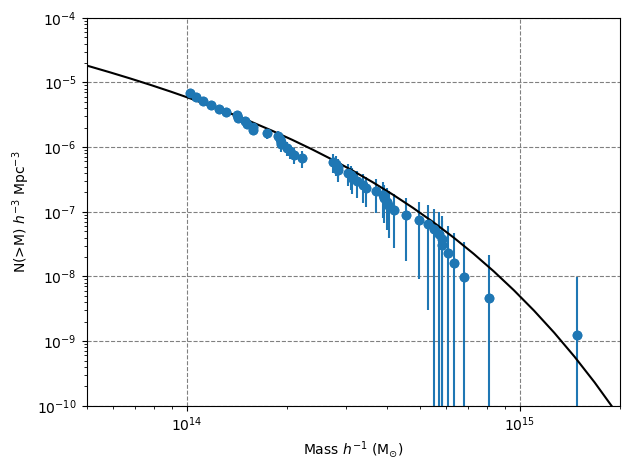

In [6]:
# Observed data
masses = -np.sort(-mass_low_z)
y_val = np.cumsum(1.0/effective_volume(masses*1.0e14))
y_err = np.sqrt(y_val/calc_survey_volume_low_z(H_0)) # Poisson error bars

plt.scatter(masses*1.0e14*h, y_val/h**3)
plt.errorbar(masses*1.0e14*h, y_val/h**3, y_err/h**3, fmt='o')


# Theoretical model
plt.plot(tmp_M*h, dN_dlnM, color='k')



# Make plot pretty
plt.gca().xaxis.grid(color='gray', linestyle='dashed')
plt.gca().yaxis.grid(color='gray', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Mass $h^{-1}$ (M$_{\odot}$)')
plt.ylabel(r'N(>M) $h^{-3}$ Mpc$^{-3}$')

plt.xlim(5.0e13, 2.0e15)
plt.ylim(1.0e-10, 1.0e-4)

plt.tight_layout()
plt.show()

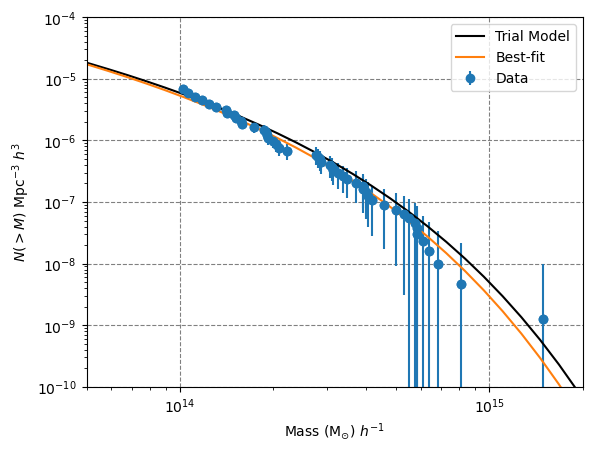

In [7]:
from scipy.optimize import minimize


# Calculate the x-, y-data
masses = -np.sort(-mass_low_z)
data_x = masses*1.0e14*h
data_y = np.cumsum(1.0/effective_volume(masses*1.0e14)) / h**3
data_y_err = np.sqrt(y_val/calc_survey_volume_low_z(H_0))/h**3 # Poisson error bars




def calc_ln_likelihood(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err):
    
    # Calculate over a mass grid
    tmp_M = np.logspace(16, 10, 100)
    bin_width = np.log10(tmp_M[0])-np.log10(tmp_M[1])

    # Calculate over the mass grid
    dN_dlnM_model = np.zeros(len(tmp_M))
    for i, mass in enumerate(tmp_M):
        dN_dlnM_model[i] = calc_dN_dlnM(mass, H_0, sigma_8, Omega_M)

    model_y = np.cumsum(dN_dlnM_model * bin_width / calc_survey_volume_low_z(H_0))
    
    # Chi2 likelihood
    ln_likelihood = 0.0
    for j in range(len(data_x)):
        idx = np.argmin(np.abs(data_x[j]-tmp_M*h))
        ln_likelihood += -(model_y[idx] - data_y[j])**2 / (2.0*data_y_err[j]**2)
        
            
    return ln_likelihood


def calc_neg_ln_likelihood(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err):
    return -calc_ln_likelihood(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)





masses = -np.sort(-mass_low_z)
y_val = np.cumsum(1.0/effective_volume(masses*1.0e14))
y_err = np.sqrt(y_val/calc_survey_volume_low_z(H_0))/h**3 # Poisson error bars


# Observed model
plt.scatter(data_x, data_y)
plt.errorbar(data_x, data_y, y_err, fmt='o', label='Data')

# Theoretical model
plt.plot(tmp_M*h, dN_dlnM, color='k', label='Trial Model')



# Run a minimization algorithm
sol = minimize(calc_neg_ln_likelihood, 0.6, 
               args=(Omega_M, H_0, data_x, data_y, data_y_err), 
               tol=1.0e-10)

# Select the minimization solution
sigma_8_best = sol.x



tmp_M = np.logspace(16, 10, 100)
bin_width = np.log10(tmp_M[0])-np.log10(tmp_M[1])

# Model Definition
dN_dlnM_model = np.zeros(len(tmp_M))

for i, mass in enumerate(tmp_M):
    dN_dlnM_model[i] = calc_dN_dlnM(mass, H_0, sigma_8_best, Omega_M)
    
dN_dlnM_model = np.cumsum(dN_dlnM_model * bin_width / calc_survey_volume_low_z(H_0))    

# Theoretical model
plt.plot(tmp_M*h, dN_dlnM_model, color='C1', label='Best-fit')


# Add the legend
plt.legend()


# Make the plot pretty
plt.gca().xaxis.grid(color='gray', linestyle='dashed')
plt.gca().yaxis.grid(color='gray', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.xlim(5.0e13, 2.0e15)
plt.ylim(1.0e-10, 1.0e-4)

plt.xlabel(r'Mass (M$_{\odot}$) $h^{-1}$')
plt.ylabel(r'$N(>M)$ Mpc$^{-3}$ $h^{3}$')



plt.show()

### Let's plot the constraints in our parameter space

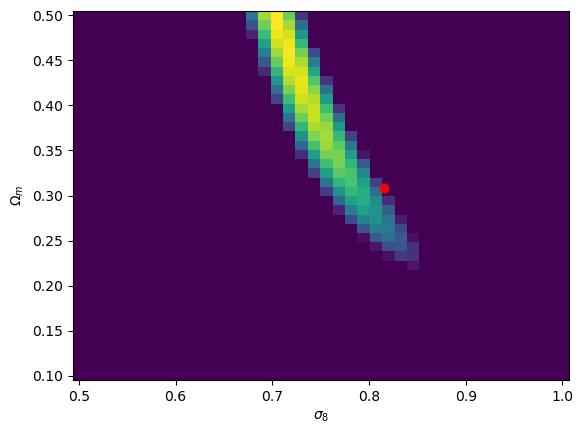

In [8]:
H_0 = H_0_trial

# Create our grid
N_side = 40
sigma_8_set = np.linspace(0.5, 1.0, N_side)
Omega_M_set = np.linspace(0.1, 0.5, N_side)
XX, YY = np.meshgrid(sigma_8_set, Omega_M_set)

# Run the likelihood calculation
ln_likelihood = np.zeros((len(sigma_8_set), len(Omega_M_set)))
for i, sigma_8 in enumerate(sigma_8_set):
    for j, Omega_M in enumerate(Omega_M_set):        
        ln_likelihood[j,i] = calc_ln_likelihood(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)


# Plot the likelihood
plt.pcolor(XX, YY, ln_likelihood,
           norm=colors.Normalize(vmin=np.max(ln_likelihood)-20.0, vmax=np.max(ln_likelihood)),
           cmap='viridis')    

# Plot the trial value
plt.scatter(sigma_8_trial, Omega_M_trial, color='r')


# Add labels
plt.xlabel(r'$\sigma_8$')
plt.ylabel(r'$\Omega_m$')

plt.show()

Notice there is a degeneracy in the $\sigma_8$-$\Omega_m$ plane. Copy the code block above into the empty block below, and replace $\Omega_m$ with $H_0$ to show any degeneracy between $\sigma_8$ and $H_0$. Remember to reset the value of $\Omega_m$ to the trial value.

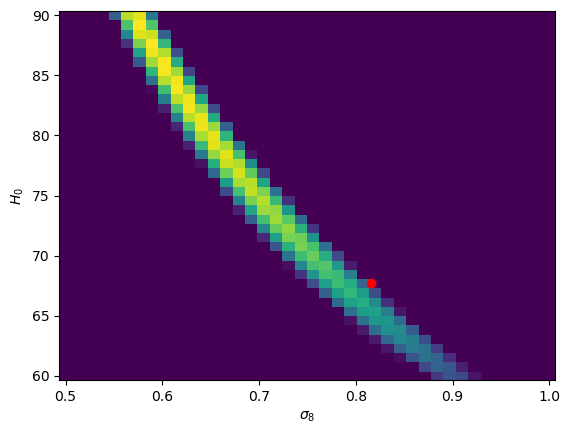

In [9]:
Omega_M = Omega_M_trial

N_side = 40
sigma_8_set = np.linspace(0.5, 1.0, N_side)
H_0_set = np.linspace(60, 90, N_side)
XX, YY = np.meshgrid(sigma_8_set, H_0_set)

ln_likelihood = np.zeros((len(sigma_8_set), len(H_0_set)))

for i, sigma_8 in enumerate(sigma_8_set):
    for j, H_0 in enumerate(H_0_set):        
        ln_likelihood[j,i] = calc_ln_likelihood(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)


        
plt.pcolor(XX, YY, ln_likelihood,
           norm=colors.Normalize(vmin=np.max(ln_likelihood)-20.0, 
                                 vmax=np.max(ln_likelihood)),
           cmap='viridis')    

plt.scatter(sigma_8_trial, H_0_trial, color='r')



plt.xlabel(r'$\sigma_8$')
plt.ylabel(r'$H_0$')

plt.show()

### Exercise: Test different cosmological parameters

It's really annoying to have to plot distributions like this in three dimensions. To get a feel for how things change with cosmological parameters, vary $\Omega_M$ and $H_0$ in the code blocks above. What happens when you increase $H_0$ to values above 75 km/s/Mpc? When you decrease to values below 65 km/s/Mpc? What happens when you increase $\Omega_M$ to values above 0.4? To values below 0.2?

## Adding priors

Our test above has provided us with a likelihood on a particular set of cosmological parameters ($H_0$, $\Omega_M$, $\sigma_8$). Let's remember our likelihood function. We've already calculated this.
$$ P({\rm data} | H_0, \Omega_M, \sigma_8)$$ 



But what we really want to know is the posterior distribution on the model parameters, $P(H_0, \Omega_M, \sigma_8 | {\rm data})$. So we use Bayes's theorem:

$$ P(H_0, \Omega_M, \sigma_8 | {\rm data}) \sim P({\rm data} | H_0, \Omega_M, \sigma_8) P(H_0, \Omega_M, \sigma_8) $$

How do we deal with our prior: $P(H_0, \Omega_M, \sigma_8)$? One way is to just assume flat priors. Without any additional information, this is often (but not always!) a reasonable assumption. For flat priors, $P(H_0, \Omega_M, \sigma_8) = {\rm constant}$, in which case the posterior distribution mimics the likelihood distribution above.

Early cosmologists did not believe in dark energy, and thought that $\Omega_M = 1$. To mimic this, add a power law prior on $\Omega_M$:
$$ P(\Omega_M) = \Omega_M^{\alpha}, $$

where $\alpha$ is the power law exponent. Note that this prior is unnormalized. However in this case, we can ignore constants that can be divided out. Fill in the prior function below with a value of $\alpha$ and show the joint constraints on $\Omega_M$ and $\sigma_8$ as done previously.

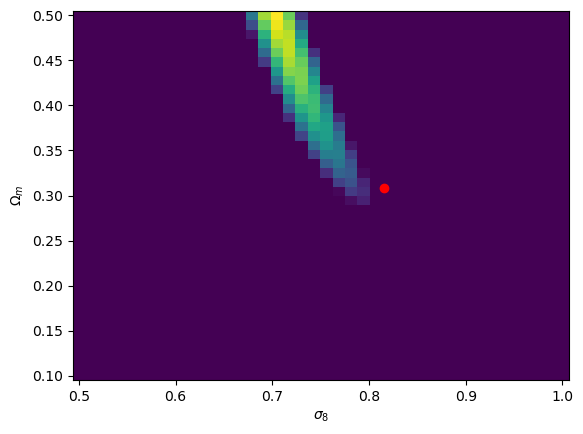

In [10]:
def calc_ln_posterior(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err):
    
    ln_prior = calc_ln_prior(sigma_8, Omega_M, H_0)
    ln_likelihood = calc_ln_likelihood(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)
    
    ln_posterior = ln_prior + ln_likelihood
            
    return ln_posterior



def calc_ln_prior(sigma_8, Omega_M, H_0):
    
    # Remember this is the log prior, not the prior. Check your math!
    ln_prior = np.log(Omega_M**20)
    
    return ln_prior



H_0 = H_0_trial

N_side = 40
sigma_8_set = np.linspace(0.5, 1.0, N_side)
Omega_M_set = np.linspace(0.1, 0.5, N_side)
XX, YY = np.meshgrid(sigma_8_set, Omega_M_set)

ln_posterior = np.zeros((len(sigma_8_set), len(Omega_M_set)))

for i, sigma_8 in enumerate(sigma_8_set):
    for j, Omega_M in enumerate(Omega_M_set):        
        ln_posterior[j,i] = calc_ln_posterior(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)

        
plt.pcolor(XX, YY, ln_posterior,
           norm=colors.Normalize(vmin=np.max(ln_posterior)-20.0, vmax=np.max(ln_posterior)),
           cmap='viridis')    

plt.scatter(sigma_8_trial, Omega_M_trial, color='r')



plt.xlabel(r'$\sigma_8$')
plt.ylabel(r'$\Omega_m$')

plt.show()

### Exercise: How large does $\alpha$ have to be before the effect from the prior distribution on $\Omega_M$ is noticeable?

### Realistic Prior

But this is cosmology, and we have lots of constraints from extra information from other observables. Let's include those as priors on $H_0$, $\Omega_M$, and $\sigma_8$. We can start by adding data from lensing, as measured by _Planck_.

$$ \sigma_8 \Omega_m^{0.25} = 0.589\pm0.020 $$

Code this prior up in the function below.

In [11]:
def calc_ln_prior(sigma_8, Omega_M, H_0):

    # Lensing data
    sigma_8_omega_M_25 = 0.589
    sigma_8_omega_M_25_err = 0.020
    
    var = sigma_8*Omega_M**(0.25) 
    
    ln_prior = -(sigma_8_omega_M_25 - sigma_8*Omega_M**(0.25))**2/(2.0*sigma_8_omega_M_25_err**2)
    
    return ln_prior

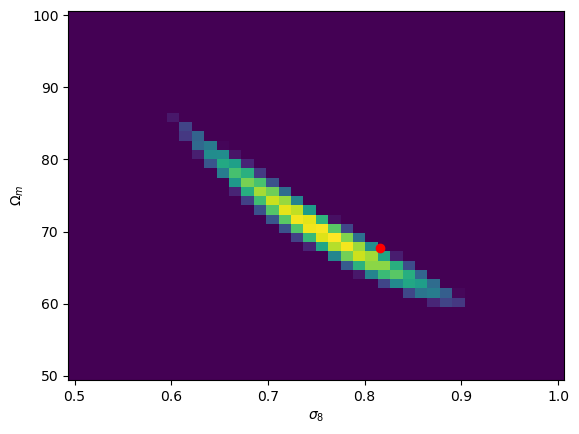

In [12]:
Omega_M = Omega_M_trial

N_side = 40
sigma_8_set = np.linspace(0.5, 1.0, N_side)
H_0_set = np.linspace(50, 100, N_side)
XX, YY = np.meshgrid(sigma_8_set, H_0_set)

ln_posterior = np.zeros((len(sigma_8_set), len(H_0_set)))

for i, sigma_8 in enumerate(sigma_8_set):
    for j, H_0 in enumerate(H_0_set):        
        ln_posterior[j,i] = calc_ln_posterior(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)


plt.pcolor(XX, YY, ln_posterior,
           norm=colors.Normalize(vmin=np.max(ln_posterior)-20.0, 
                                 vmax=np.max(ln_posterior)),
           cmap='viridis')    

plt.scatter(sigma_8_trial, H_0_trial, color='r')


# Make the plot pretty

plt.xlabel(r'$\sigma_8$')
plt.ylabel(r'$\Omega_m$')

plt.show()

### Now, in the code blocks below, use a different prior which employs the full constraints from _Planck_.

$$ H_0 = 67.9\pm1.2\ {\rm km}\ {\rm s}^{-1}\ {\rm Mpc} $$
$$ \sigma_8 = 0.811 \pm 0.019 $$
$$ \Omega_m = 0.303 \pm 0.017 $$

Remake the joint plots shown above using the updated Planck priors.

In [13]:
def calc_ln_prior(sigma_8, Omega_M, H_0):

    planck_H_0 = 67.9
    planck_H_0_err = 1.2
    planck_sigma_8 = 0.811
    planck_sigma_8_err = 0.019
    planck_Omega_M = 0.303
    planck_Omega_M_err = 0.017
    
    ln_prior = -(planck_H_0 - H_0)**2 / (2.0 * planck_H_0_err**2)
    ln_prior += -(planck_sigma_8 - sigma_8)**2 / (2.0 * planck_sigma_8_err**2)
    ln_prior += -(planck_Omega_M - Omega_M)**2 / (2.0 * planck_Omega_M_err**2)

    return ln_prior

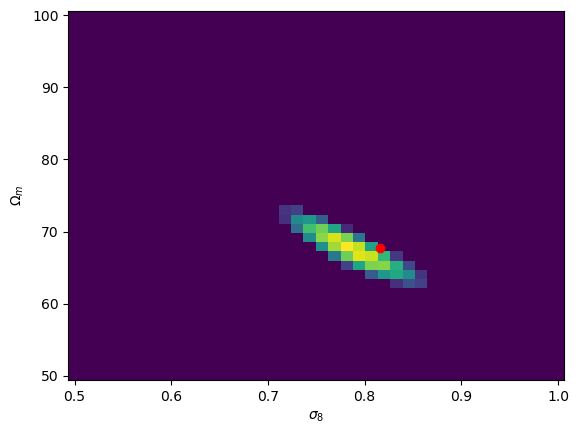

In [14]:
Omega_M = Omega_M_trial

N_side = 40
sigma_8_set = np.linspace(0.5, 1.0, N_side)
H_0_set = np.linspace(50, 100, N_side)
XX, YY = np.meshgrid(sigma_8_set, H_0_set)

ln_posterior = np.zeros((len(sigma_8_set), len(H_0_set)))

for i, sigma_8 in enumerate(sigma_8_set):
    for j, H_0 in enumerate(H_0_set):        
        ln_posterior[j,i] = calc_ln_posterior(sigma_8, Omega_M, H_0, data_x, data_y, data_y_err)


plt.pcolor(XX, YY, ln_posterior,
           norm=colors.Normalize(vmin=np.max(ln_posterior)-20.0, 
                                 vmax=np.max(ln_posterior)),
           cmap='viridis')    

plt.scatter(sigma_8_trial, H_0_trial, color='r')


# Make the plot pretty

plt.xlabel(r'$\sigma_8$')
plt.ylabel(r'$\Omega_m$')

plt.show()

### Extra credit: Use `scipy.optimize.minimize` to find the maximum a posteriori point in 3D parameter space

### Discuss with your partner how one might go about combining separate data sets to produce *joint* constraints on cosmological parameters

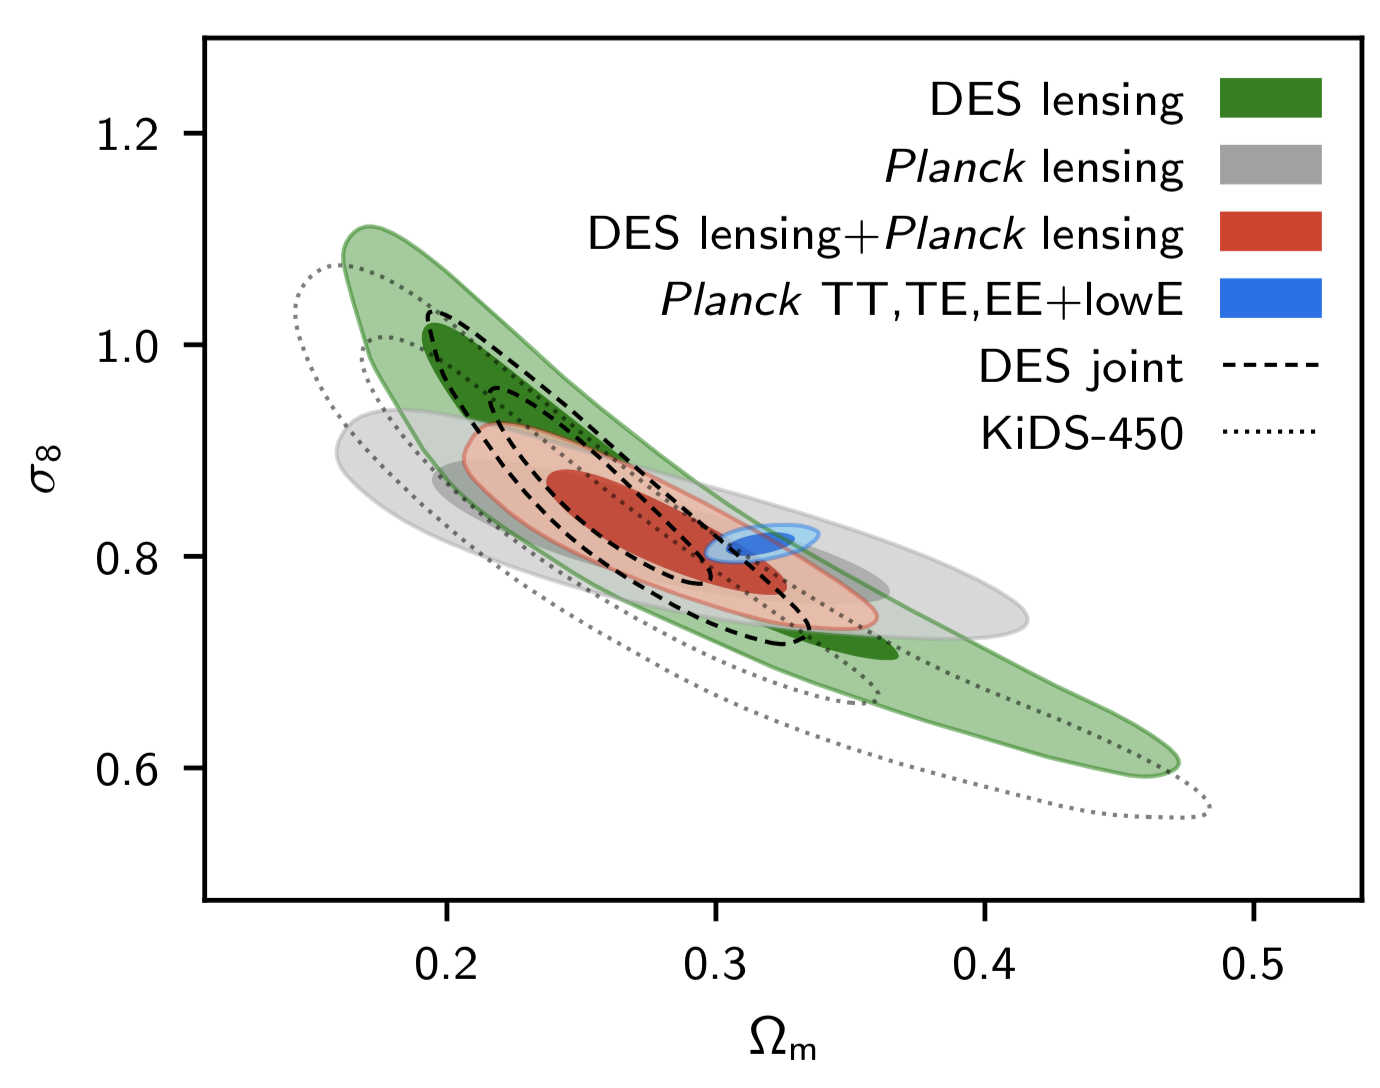

In [15]:
from IPython.display import Image
Image(data = 'images/Planck.png', width=500)

From above, we have Bayes's Theorem:

$$ P(H_0, \Omega_M, \sigma_8 | {\rm data}) \sim P({\rm data} | H_0, \Omega_M, \sigma_8) P(H_0, \Omega_M, \sigma_8) $$

But now, we have multiple types of data. These can be split:

$$ P(H_0, \Omega_M, \sigma_8 | {\rm Planck\ data}, {\rm BAO\ data}, {\rm DES\ lensing}, ...) \sim P({\rm Planck\ data} | H_0, \Omega_M, \sigma_8) $$
 $$ \times P({\rm BAO\ data} | H_0, \Omega_M, \sigma_8) $$
 $$ \times P({\rm DES\ lensing} | H_0, \Omega_M, \sigma_8) $$
 $$ \times P({\rm other\ data} | H_0, \Omega_M, \sigma_8) $$
 $$ \times P(H_0, \Omega_M, \sigma_8) $$